# Data Analysis for Amazon Toys and Games reviews datasets
###### Piotr Stachowicz, Jakub Malczak

### Config

In [1]:
FILE = "Amazon_Toys_and_Games"
CLEAN = True

### 1. Dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.json as pjs
import json
import seaborn as sns

In [3]:
def clean(inp_path: str, out_path: str, columns: list[str]) -> None:
    with open(inp_path, 'r') as f, open(out_path, 'w+') as w:
        for row in f:
            entry = json.loads(row)

            new_entry = dict()

            for col in columns:
                try:
                    new_entry[col] = entry[col]
                except Exception:
                    print(f'There was an error while creating new entry! Probably {col} does not exist in input file!')

            w.write(json.dumps(new_entry) + '\n')

def convert_metadata(inp_path: str, out_path: str):
    with open(inp_path, 'r') as f, open(out_path, 'w+') as w:
            for line in f:
                data = json.loads(line)
                asin = data['parent_asin']
                categories = data.get('categories', [])

                if not categories:
                    continue

                category = categories[-1][-1] if isinstance(categories[-1], list) else categories[-1]
                
                new_entry = {
                    'parent_asin': asin,
                    'category': category
                }

                w.write(json.dumps(new_entry) + '\n')

### 2. Dataset loading

In [ ]:
if CLEAN:
    dataset = f"./{FILE}.jsonl"
    meta = f"./meta_{FILE}.jsonl"

    clean(
        dataset, 
        f"./{FILE}_cleaned.jsonl", 
        ['rating', 'asin', 'parent_asin', 'user_id', 'timestamp', 'verified_purchase']
    )
    convert_metadata(meta, f"./meta_{FILE}_cleaned.jsonl")

dataset = f"./{FILE}_cleaned.jsonl"
meta = f"./meta_{FILE}_cleaned.jsonl"

try:
    df: pd.DataFrame = pjs.read_json(dataset, parse_options=pjs.ParseOptions()).to_pandas()
except Exception:
    raise Exception(f"Error while loading file: {dataset}")

### 3. Fun statistics

#### 3.1 Data structure

In [6]:
df.head()

,rating,asin,parent_asin,user_id,timestamp,verified_purchase
0,5.0,B09QH7QJS7,B09QH7QJS7,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1677939664713,True
1,3.0,B06XYKSKQP,B06XYKSKQP,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1639855230760,True
2,5.0,B07SFF3YQW,B07XRSD5R9,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1580949719154,True
3,5.0,B007JWWUDW,B007JWWUDW,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1471542588000,True
4,3.0,B00MZG6OO8,B00MZG6OO8,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1471541996000,True


In [7]:
df.keys()

Index(['rating', 'asin', 'parent_asin', 'user_id', 'timestamp',
       'verified_purchase'],
      dtype='object')

#### 3.2 Unique Users & Products

In [8]:
unique_users = df['user_id'].nunique()
unique_products = df['asin'].nunique()

print(f"Number of unique users: {unique_users}")
print(f"Number of unique products: {unique_products}")

Number of unique users: 8116226
Number of unique products: 1019719


#### 3.3 Average Rating

In [9]:
ratings = df.shape[0]
avg_rating = df['rating'].sum() / ratings

print(f"Average rating is: {avg_rating}")

Average rating is: 4.2108097423889665


In [10]:
print(ratings)

16260406


#### 3.4 Average Reviews per User

In [11]:
avg_user_reviews = ratings / unique_users

print(f"Average reviews per user: {avg_user_reviews}")

Average reviews per user: 2.003444211632352


#### 3.5 Average Reviews per Product

In [12]:
avg_product_reviews = ratings / unique_products

print(f"Average reviews per product: {avg_product_reviews}")

Average reviews per product: 15.945967467508206


#### 3.6 Number of reviews per user

In [13]:
user_counts = df.groupby("user_id").size().reset_index(name="review_count")

##### 3.6.1 Top 10 reviewers

In [14]:
user_counts.sort_values('review_count', ascending=False).head(10)

,user_id,review_count
6086168,AGZZXSMMS4WRHHJRBUJZI4FZDHKQ,2954
4131049,AG375WAXLZ7PIOQKIQ6KQB4J3JVQ,1120
4376916,AG73BVBKUOH22USSFJA5ZWL7AKXA,1042
917384,AEIIRIHLIYKQGI7ZOCIJTRDF5NPQ,1022
1862620,AEXGISIVX7WBUNI7UHHERVB3DF7Q,866
3382144,AFPF2CONJ33FNFKOEQ2TUNWQJTFQ,721
2764981,AFFNI6O4TK5UFNWJVDTCOUQAO2UA,661
5757746,AGUTZC4GHLTGYHA3KBEDRF6MHB6A,633
3677506,AFTZWAK3ZHAPCNSOT5GCKQDECBTQ,616
886692,AEHZBUFEOW4TY3K4IYFFR5ZU5B3Q,597


##### 3.6.2 Distribution plot

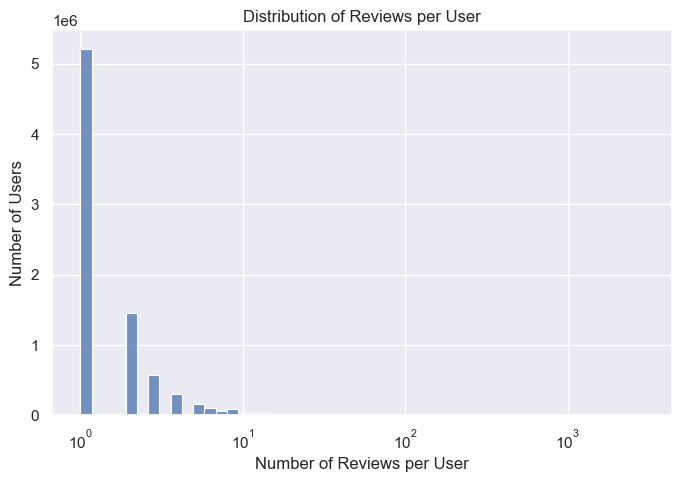

In [15]:
plt.figure(num=0, figsize=(8, 5))
sns.set_theme(style="darkgrid")

sns.histplot(
    user_counts['review_count'], 
    bins=50, log_scale=True
)

plt.xlabel("Number of Reviews per User")
plt.ylabel("Number of Users")
plt.title("Distribution of Reviews per User")

plt.show()

#### 3.7 User x Product Matrix Sparsity

In [16]:
matrix_size = unique_users * unique_products
matrix_sparsity = 1.0 - (ratings / matrix_size)

print(f"Matrix sparsity of dataset: {matrix_sparsity}%")

Matrix sparsity of dataset: 0.999998035297752%


#### 3.8 Number of reviews per product

In [17]:
product_counts = df.groupby(["asin"]).size().reset_index(name="review_count")

##### 3.8.1 Top 10 reviewed products

In [18]:
product_counts.sort_values(by="review_count", ascending=False).head(10)

,asin,review_count
120764,B004S8F7QM,18698
48591,B000YDDF6O,11348
297401,B010TQY7A8,8871
8983,B00005C5H4,7590
122625,B004V3PS72,6561
377447,B01MRG7T0D,6173
324829,B01AC7SF7K,5851
183886,B00ABA0ZOA,5711
22155,B000B6ACGA,5537
308412,B0157IHJMQ,5483


##### 3.8.2 Distribution plot

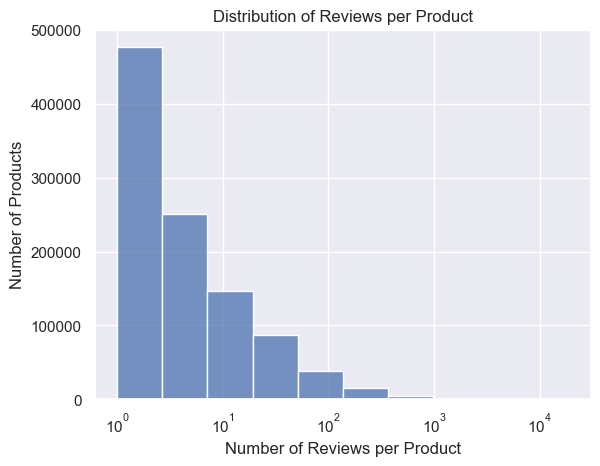

In [19]:
plt.figure(num=1)
sns.set_theme(style="darkgrid")

sns.histplot(
    data=product_counts['review_count'], 
    bins=10,
    log_scale=True
)

plt.xlabel("Number of Reviews per Product")
plt.ylabel("Number of Products")
plt.title("Distribution of Reviews per Product")

plt.show()

#### 3.9 Product lifespan analysis

In [20]:
lifespan_df = df.groupby(by='asin')['timestamp'].agg(['min', 'max'])
lifespan_df['max'] = pd.to_datetime(lifespan_df['max'], unit='ms')
lifespan_df['min'] = pd.to_datetime(lifespan_df['min'], unit='ms')

lifespan_df['lifespan'] = lifespan_df['max'] - lifespan_df['min']
lifespan_df['lifespan'] = lifespan_df['lifespan'].dt.days

In [21]:
lifespan_df = lifespan_df[lifespan_df['lifespan'] != 0]

lifespan_df.head()

,min,max,lifespan
asin,,,
0006466222,2015-01-14 17:37:04.000,2022-07-29 20:30:02.736,2753
0020232233,2017-03-02 21:52:21.000,2022-11-04 22:49:36.145,2073
0160936195,2019-06-16 17:42:54.258,2023-01-30 20:11:31.363,1324
0201399636,2022-03-23 19:50:30.095,2023-02-18 17:37:38.658,331
024142691X,2021-09-01 23:59:16.294,2021-10-11 11:52:50.335,39


##### 3.9.1 Product lifespan distribution

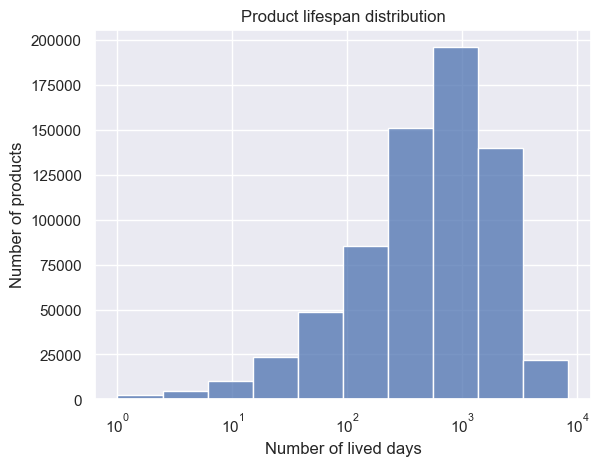

In [22]:
plt.figure(num=3)
sns.histplot(
    lifespan_df['lifespan'],
    log_scale=True,
    bins=10
)
plt.xlabel("Number of lived days")
plt.ylabel("Number of products")
plt.title("Product lifespan distribution")
plt.show()

##### 3.9.2 Seasonality of products

In [23]:
seasonality_df = df.copy()
seasonality_df['timestamp'] = pd.to_datetime(seasonality_df['timestamp'], unit='ms')

In [24]:
seasonality_df = seasonality_df[seasonality_df['verified_purchase'] == True]

In [25]:
seasonality_df.head()

,rating,asin,parent_asin,user_id,timestamp,verified_purchase
0,5.0,B09QH7QJS7,B09QH7QJS7,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2023-03-04 14:21:04.713,True
1,3.0,B06XYKSKQP,B06XYKSKQP,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2021-12-18 19:20:30.760,True
2,5.0,B07SFF3YQW,B07XRSD5R9,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-02-06 00:41:59.154,True
3,5.0,B007JWWUDW,B007JWWUDW,AGKASBHYZPGTEPO6LWZPVJWB2BVA,2016-08-18 17:49:48.000,True
4,3.0,B00MZG6OO8,B00MZG6OO8,AGKASBHYZPGTEPO6LWZPVJWB2BVA,2016-08-18 17:39:56.000,True


In [26]:
seasonality_df.set_index('timestamp', inplace=True)

In [27]:
monthly_transaction_count = seasonality_df['verified_purchase'].resample('MS').count().reset_index(name="purchase_count")
monthly_transaction_count.head(10)

,timestamp,purchase_count
0,2000-08-01,2
1,2000-09-01,5
2,2000-10-01,3
3,2000-11-01,7
4,2000-12-01,9
5,2001-01-01,10
6,2001-02-01,4
7,2001-03-01,1
8,2001-04-01,4
9,2001-05-01,3


##### 3.9.3 Top 20 highest selling months

In [28]:
monthly_transaction_count.sort_values(by='purchase_count', ascending=False).head(20)

,timestamp,purchase_count
233,2020-01-01,372836
232,2019-12-01,324757
245,2021-01-01,261706
244,2020-12-01,257192
234,2020-02-01,238192
221,2019-01-01,233049
268,2022-12-01,229105
257,2022-01-01,226321
269,2023-01-01,221523
256,2021-12-01,219963


##### 3.9.4 Time series

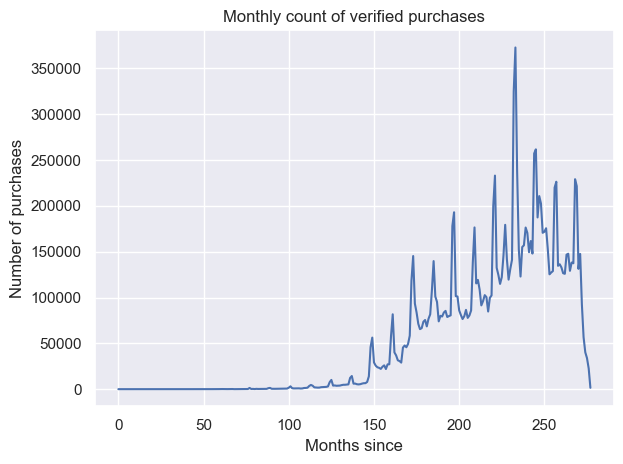

In [29]:
plt.figure(num=4)
monthly_transaction_count['purchase_count'].plot(title="Monthly count of verified purchases")
plt.xlabel('Months since')
plt.ylabel('Number of purchases')
plt.tight_layout()
plt.grid(True)
plt.show()

In [30]:
month_subseries_count = monthly_transaction_count.copy()
month_subseries_count['month'] = month_subseries_count['timestamp'].dt.month

foo = month_subseries_count.groupby(by='month')['purchase_count'].sum().reset_index(name='purchase_count')
foo.head(12)

,month,purchase_count
0,1,2143072
1,2,1320225
2,3,1247009
3,4,1073312
4,5,1015484
5,6,1023443
6,7,1135700
7,8,1072523
8,9,918656
9,10,989224


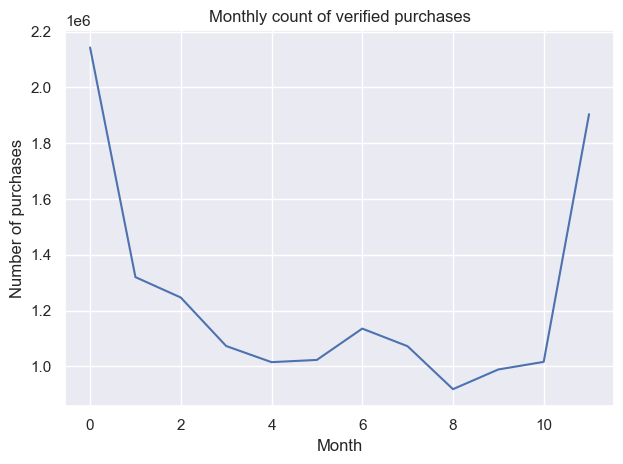

In [31]:
plt.figure(num=5)
foo['purchase_count'].plot(title="Monthly count of verified purchases")
plt.xlabel('Month')
plt.ylabel('Number of purchases')
plt.tight_layout()
plt.grid(True)
plt.show()

#### 3.10 Rating distribution

In [32]:
rating_counts = df['rating'].value_counts().sort_index()
rating_counts.head()

rating
1.0     1631131
2.0      767908
3.0     1103648
4.0     1797010
5.0    10960709
Name: count, dtype: int64

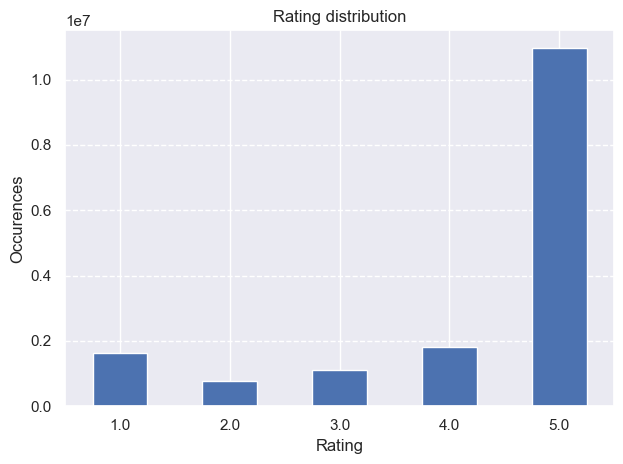

In [33]:
plt.figure(num=6)
rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Occurences')
plt.title('Rating distribution')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

#### 3.11 Subclasses

In [34]:
try:
    df2: pd.DataFrame = pjs.read_json(meta, parse_options=pjs.ParseOptions()).to_pandas()
except Exception:
    raise Exception(f"Error while loading file: {meta}")

In [35]:
df2.head()

,parent_asin,category
0,B09X9XW42H,Plush Figures
1,B01I9QET6M,Décor
2,B019XEEX1A,Trucks
3,B09G7K3JWQ,Pre-Kindergarten Toys
4,B0BQJGV4ZM,Paint-By-Number Kits


In [36]:
df2 = pd.merge(df, df2, on='parent_asin', how='left')

In [37]:
df2.head()

,rating,asin,parent_asin,user_id,timestamp,verified_purchase,category
0,5.0,B09QH7QJS7,B09QH7QJS7,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1677939664713,True,Playsets
1,3.0,B06XYKSKQP,B06XYKSKQP,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1639855230760,True,Action Figures
2,5.0,B07SFF3YQW,B07XRSD5R9,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1580949719154,True,Booster Packs
3,5.0,B007JWWUDW,B007JWWUDW,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1471542588000,True,"Cars, Trucks, Boats & Planes"
4,3.0,B00MZG6OO8,B00MZG6OO8,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1471541996000,True,"Cars, Trucks, Boats & Planes"


In [38]:
subcategories_df = df2.dropna(subset=['category'])
unique_parent_asins_in_subcategory = subcategories_df[['parent_asin', 'category']].drop_duplicates()
product_count_by_subcategory = unique_parent_asins_in_subcategory.groupby('category')['parent_asin'].count().sort_values(ascending=False)

In [39]:
product_count_by_subcategory.head()

category
Action Figures           46914
Pre-Kindergarten Toys    38838
Jigsaw Puzzles           30282
Board Games              26444
Balloons                 24113
Name: parent_asin, dtype: int64

In [40]:
top_n_subcategories = product_count_by_subcategory.head(20)
others_count = product_count_by_subcategory.iloc[20:].sum()

if others_count > 0:
    top_n_subcategories['Other'] = others_count

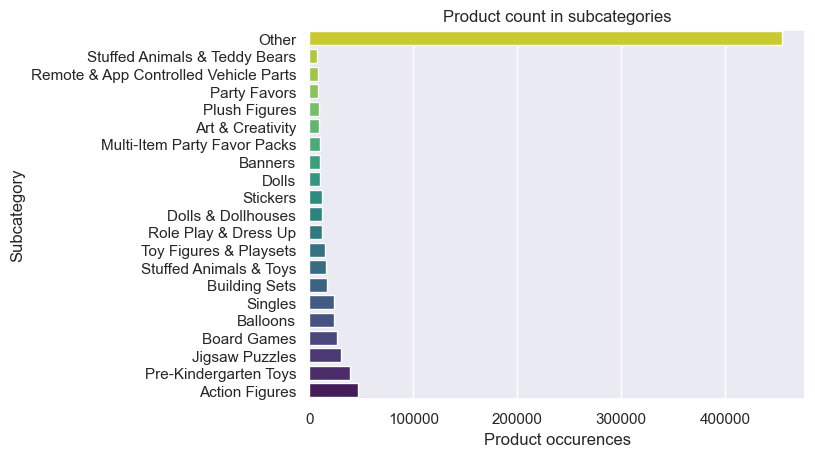

In [41]:
barplot = sns.barplot(x=top_n_subcategories.values, y=top_n_subcategories.index, palette="viridis", hue=top_n_subcategories.index, dodge=False, legend=False)
plt.xlabel('Product occurences')
plt.ylabel('Subcategory')
plt.title(f'Product count in subcategories')
plt.gca().invert_yaxis()

### 4.0 Check photo availability

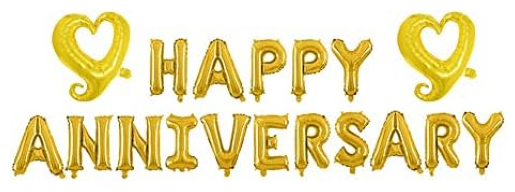

In [42]:
import requests
from PIL import Image
from io import BytesIO

with open(f'./meta_{FILE}.jsonl', 'r') as f:
    data = f.readline()
    first = json.loads(data)

    image_url = first['images'][0]['large']

    response = requests.get(image_url, stream=True)
    response.raise_for_status()

    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
